# set up

In [3]:
!pip3 install --upgrade tensorflow
!pip install --upgrade tensorflow-hub
!pip install scikit-learn
!pip install seaborn
!pip install keras
!pip install tensorflow
!pip install tensorflow_hub
!pip install opendatasets
#!pip install --user numpy scipy matplotlib ipython jupyter pandas sympy nose
!pip3 install --user scipy  # install using python3

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: tensorflow in /home/hanzin/.local/lib/python3.7/site-packages (2.9.1)
You should consider upgrading via the '/usr/local/anaconda3/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: tensorflow-hub in /home/hanzin/.local/lib/python3.7/site-packages (0.12.0)


You should consider upgrading via the '/usr/local/anaconda3/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/anaconda3/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/anaconda3/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/anaconda3/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/local/anaconda3/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/anaconda3/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/anaconda3/bin/python -m pip install --upgrade pip' command.


In [3]:
#Import libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import random

from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator


from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Model
from tensorflow.keras import optimizers

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score,recall_score,accuracy_score,precision_score

import scipy

Extracting Files

In [24]:
train_ds='./XRayData/trainset'
test_ds='./XRayData/testset'
val_ds='./XRayData/valset'
train_covid=os.listdir(train_ds+'/COVID')
train_normal=os.listdir(train_ds+'/Normal')
train_Viral_Pneumonia=os.listdir(train_ds+'/Viral Pneumonia')
print('trian size COVID',len(train_covid))
print('trian size Normal',len(train_normal))
print('trian size Viral Pneumonia',len(train_Viral_Pneumonia))

trian size COVID 3216
trian size Normal 9792
trian size Viral Pneumonia 945


In [5]:
test_COVID=os.listdir(test_ds+'/COVID')
test_Normal=os.listdir(test_ds+'/Normal')
test_Viral_Pneumonia=os.listdir(test_ds+'/Viral Pneumonia')


print('test size COVID ',len(test_COVID))
print('test size large ',len(test_Normal))
print('test size Viral Pneumonia ',len(test_Viral_Pneumonia))


test size COVID  200
test size large  200
test size Viral Pneumonia  200


# Exploratory Data Analysis

In [9]:
filenames = os.listdir(train_ds+'/COVID')+os.listdir(train_ds+'/Normal')+os.listdir(train_ds+'/Viral Pneumonia')
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append('COVID')
    elif category == 'Viral Pneumonia':
        categories.append('Viral Pneumonia')
    else:
        categories.append('Normal')

for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(train_ds+'/COVID', filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(train_ds+'/Viral Pneumonia', filenames[i])
    else:
        filenames[i] = os.path.join(train_ds+'/Normal', filenames[i])
    
    
trainds = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


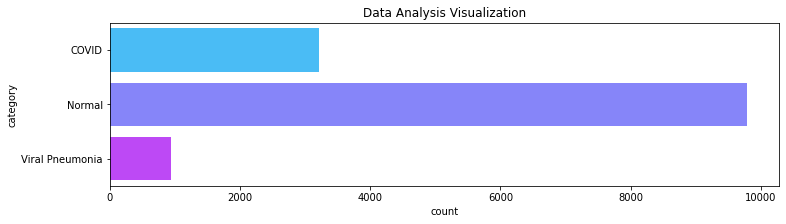

In [10]:
#Exploratory Data Analysis
plt.figure(figsize=(12,3))
plt.title('Data Analysis Visualization')
splot = sns.countplot(data = trainds.sort_values(by='category'), y ='category', palette='cool', saturation=0.9)

plt.show()

Classes

1 -> COVID-19 

2 -> Normal 

3 -> Viral Pneumonia

# Data Visualization

COVID


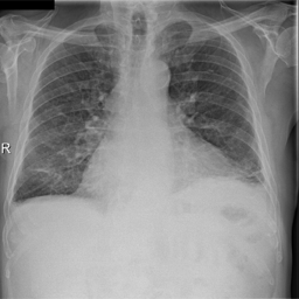

Normal


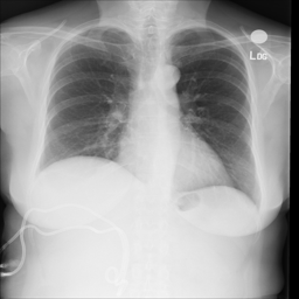

Viral Pneumonia


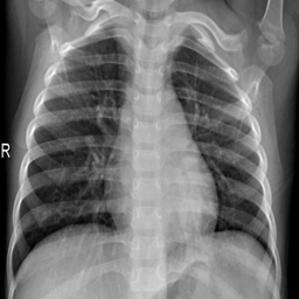

In [28]:
from IPython.display import Image 


image_COVID = Image('./XRayData/trainset/COVID/'+train_covid[0])

image_Normal = Image('./XRayData/trainset/Normal/'+train_normal[0])

image_Viral_Pneumonia = Image('./XRayData/trainset/Viral Pneumonia/'+train_Viral_Pneumonia[0])


print('COVID')
display(image_COVID)
print('Normal')
display(image_Normal)
print('Viral Pneumonia')
display(image_Viral_Pneumonia)

# pre-processing of images

In [8]:
#ImageDataGenerator is a class that allows pre-processing of images,
#in order to format images before using them by training and drawing a model.
#This includes resizing, orientation and color corrections.
train_datagen= ImageDataGenerator(rescale = 1./255,validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen= ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen= ImageDataGenerator(rescale = 1./255)
# Rescale 1./255 -is to transform every pixel value from range [0,255] -> [0,1]
# width_shift_range -shift the image to the left or right(horizontal shifts)
#height_shift_range -shift the image to up or down (vertically shifts).
#shear_range is Shear Intensity (Shear angle in counter-clockwise direction in degrees)
#rotation_range -randomly rotate images through any degree between 0 and 360 by providing an integer value in the rotation_range argument.

In [9]:
train_dataset  = train_datagen.flow_from_directory(directory = train_ds,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)

valid_dataset = valid_datagen.flow_from_directory(directory = val_ds,
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = test_ds,
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 13953 images belonging to 4 classes.
Found 600 images belonging to 4 classes.
Found 600 images belonging to 4 classes.


In [10]:
#data batches
#!pip install --user numpy scipy matplotlib ipython jupyter pandas sympy nose
!pip3 install --user scipy  # install using python3
import scipy
image_batch_train, label_batch_train = next(iter(train_dataset))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_dataset.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])

print('1: ',dataset_labels[1])
print('2: ',dataset_labels[2])
print('3: ',dataset_labels[3])

You should consider upgrading via the '/usr/local/anaconda3/bin/python -m pip install --upgrade pip' command.
Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 4)
1:  Covid
2:  Normal
3:  Viral Pneumonia


# Create model

In [11]:
base_model_2 = tf.keras.applications.ResNet101V2(input_shape=(224,224,3),include_top=False,weights="imagenet")
# Freezing Layers
for layer in base_model_2.layers:
   layer.trainable = False

In [12]:
from tensorflow.keras import Model
from tensorflow.keras import optimizers
#The output of the CNN is also a 4D array. Where batch size would be the same as input batch size but the other 3 dimensions of the image might change depending upon the values of filter, kernel size, and padding we use.
x = base_model_2.output 
#A Flatten layer in Keras reshapes the tensor to have a shape that is equal to the number of elements contained in the tensor. This is the same thing as making a 1d-array of elements.
x = tf.keras.layers.Flatten()(x) 
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x) # Dropout 20 % of the layers
x = tf.keras.layers.Dense(train_dataset.num_classes, activation = "softmax")(x)
#The input layer is the input of the whole CNN.
model = Model(inputs= base_model_2.input , outputs = x)

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='acc')
]
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)     

                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 14, 14, 256)  589824      ['conv4_block6_2_pad[0][0]']     
          

                                                                                                  
 conv4_block8_out (Add)         (None, 14, 14, 1024  0           ['conv4_block7_out[0][0]',       
                                )                                 'conv4_block8_3_conv[0][0]']    
                                                                                                  
 conv4_block9_preact_bn (BatchN  (None, 14, 14, 1024  4096       ['conv4_block8_out[0][0]']       
 ormalization)                  )                                                                 
                                                                                                  
 conv4_block9_preact_relu (Acti  (None, 14, 14, 1024  0          ['conv4_block9_preact_bn[0][0]'] 
 vation)                        )                                                                 
                                                                                                  
 conv4_blo

 conv4_block11_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block11_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block11_2_pad[0][0]']    
                                                                                                  
 conv4_block11_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block11_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block11_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block11_2_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block14_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block14_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block14_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block14_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block14_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block14_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 lization)                                                                                        
                                                                                                  
 conv4_block16_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block16_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block16_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block16_out (Add)        (None, 14, 14, 1024  0           ['conv4_block15_out[0][0]',      
                                )                                 'conv4_block16_3_conv[0][0]']   
          

                                                                                                  
 conv4_block19_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block19_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block19_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block19_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block19_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block19_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_blo

                                )                                                                 
                                                                                                  
 conv4_block21_out (Add)        (None, 14, 14, 1024  0           ['conv4_block20_out[0][0]',      
                                )                                 'conv4_block21_3_conv[0][0]']   
                                                                                                  
 conv4_block22_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block21_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block22_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block22_preact_bn[0][0]']
 ivation)                       )                                                                 
          

 n)                                                                                               
                                                                                                  
 conv5_block1_2_pad (ZeroPaddin  (None, 9, 9, 512)   0           ['conv5_block1_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 512)    2359296     ['conv5_block1_2_pad[0][0]']     
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

 post_bn (BatchNormalization)   (None, 7, 7, 2048)   8192        ['conv5_block3_out[0][0]']       
                                                                                                  
 post_relu (Activation)         (None, 7, 7, 2048)   0           ['post_bn[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 100352)       0           ['post_relu[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 1024)         102761472   ['flatten[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1024)         0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (

# Compile the model

In [13]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=METRICS)

 # class weight

In [14]:
class_weight = {0:0,
                1: 3.,
                2: 1.,
                3: 10.}

# Set up callbacks

In [15]:

checkpoint_filepath = './Data/ModelCheckpoint/'
# modelCheckpoint: a callback object that can perform actions at various stages of the training, and can monitor either the accuracy or the loss
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode="auto",min_delta=0.05,verbose=1)

callbacks_list = [early_stopping,checkpoint]


# Train the model

In [16]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 10,callbacks=callbacks_list,verbose = 1,class_weight=class_weight)

Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 16.8338 - accuracy: 0.8668 - precision: 0.7338 - recall: 0.7333 - acc: 0.8479
Epoch 1: acc improved from -inf to 0.84792, saving model to ./Data/ModelCheckpoint/
219/219 [==============================] - 736s 3s/step - loss: 16.8338 - accuracy: 0.8668 - precision: 0.7338 - recall: 0.7333 - acc: 0.8479 - val_loss: 1.0404 - val_accuracy: 0.9237 - val_precision: 0.8481 - val_recall: 0.8467 - val_acc: 0.9487
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 1.2455 - accuracy: 0.9060 - precision: 0.8139 - recall: 0.8089 - acc: 0.9478
Epoch 2: acc improved from 0.84792 to 0.94782, saving model to ./Data/ModelCheckpoint/
219/219 [==============================] - 736s 3s/step - loss: 1.2455 - accuracy: 0.9060 - precision: 0.8139 - recall: 0.8089 - acc: 0.9478 - val_loss: 0.3386 - val_accuracy: 0.9329 - val_precision: 0.8677 - val_recall: 0.8633 - val_acc: 0.9779
Epoch 3/10
219/219 [=====================

In [20]:
#save model
model.save('./Model/model10ep')

INFO:tensorflow:Assets written to: ./Model/model10ep/assets


INFO:tensorflow:Assets written to: ./Model/model10ep/assets


# Plot the training and validation metrics

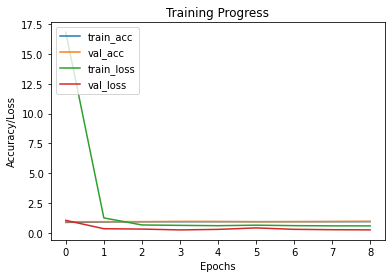

In [19]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()

        
plot_hist(history)

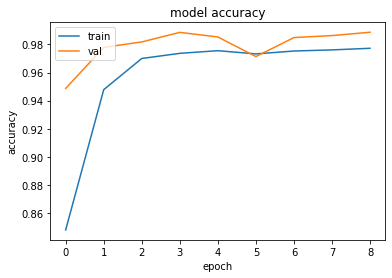

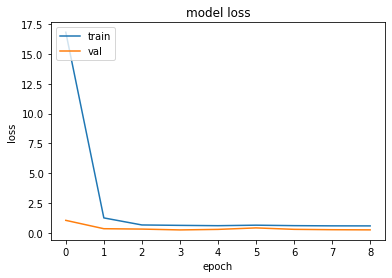

In [18]:
# list all data in history
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
y_pred=[]
model = keras.models.load_model('./Model/model10ep')
'''This function loads an image'''
def prepare_img(img, img_width, img_height,channels):
    img =  tf.keras.preprocessing.image.img_to_array(img)
    img = img.reshape(1, img_width, img_height, channels).astype('float32')
    img = img / 255.0
    return img


for img in test_COVID:
    img = tf.keras.preprocessing.image.load_img('./XRayData/testset/COVID/' + img ,target_size=(224, 224))
    img = prepare_img(img,224,224,3)
    predictions = model.predict(img)
    index_of_higher_value  = predictions[0].argmax()
    y_pred.append(predictions[0].argmax())

for img in test_Normal:
    img = tf.keras.preprocessing.image.load_img('./XRayData/testset/Normal/' + img ,target_size=(224, 224))
    img = prepare_img(img,224,224,3)
    predictions = model.predict(img)
    index_of_higher_value  = predictions[0].argmax()
    y_pred.append(predictions[0].argmax())


for img in test_Viral_Pneumonia:
    img = tf.keras.preprocessing.image.load_img('./XRayData/testset/Viral Pneumonia/' + img ,target_size=(224, 224))
    img = prepare_img(img,224,224,3)
    predictions = model.predict(img)
    index_of_higher_value = predictions[0].argmax()
    y_pred.append(predictions[0].argmax())
    



1/1 [==============================] - 0s 124ms/step


1/1 [==============================] - 0s 124ms/step


In [24]:

y_test=[1]*len(test_COVID)
y_test+=[2]*len(test_Normal)
y_test+=[3]*len(test_Viral_Pneumonia)
print('Accuracy: ',round(accuracy_score(y_test, y_pred),2))
print('Recall: ',round(recall_score(y_test, y_pred,average='weighted'),2))
print('Precision: ',round(precision_score(y_test, y_pred,average='weighted'),2))
print('f1 score :',round(f1_score(y_test,y_pred, average='weighted'),2))

print(classification_report(y_test, y_pred))

Accuracy:  0.92
Recall:  0.92
Precision:  0.92
f1 score : 0.92
              precision    recall  f1-score   support

           1       0.88      0.94      0.91       200
           2       0.89      0.87      0.88       200
           3       0.98      0.94      0.96       200

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600



COVID


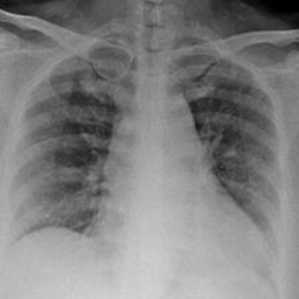

Normal


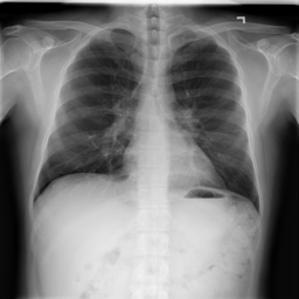

Viral Pneumonia


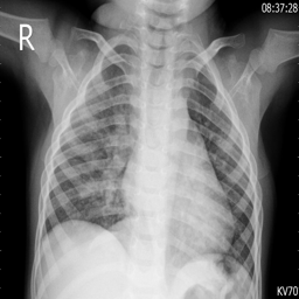

In [25]:
from IPython.display import Image 


image_COVID = Image('./XRayData/testset/COVID/'+test_COVID[0])

image_Normal = Image('./XRayData/testset/Normal/'+test_Normal[0])

image_Viral_Pneumonia = Image('./XRayData/testset/Viral Pneumonia/'+test_Viral_Pneumonia[0])


print('COVID')
display(image_COVID)
print('Normal')
display(image_Normal)
print('Viral Pneumonia')
display(image_Viral_Pneumonia)
